# THEORY

## Code

**1. Import <a href="https://numpy.org">NumPy</a>, <a href="https://matplotlib.org">matplotlib</a> and Image from <a href="https://pillow.readthedocs.io/en/stable/">PIL</a>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from time import time

**2. Load Cython extension**

In [2]:
# Load cython
%load_ext Cython

**3. Implementation of auxiliar functions and operations of Grayscale Mathematical Morphology**

In [3]:
%%cython -a
cimport numpy as cnp
import numpy as np
import random

# 
# Function that transform a color image to grayscale image
# 

def colorToGrayscale(const unsigned char[:,:,:] image_array):
    cdef int height = image_array.shape[0] 
    cdef int width = image_array.shape[1]
    cdef int i
    cdef int j
    cdef unsigned char G
    cdef gs_img_arr = np.zeros((height, width),dtype=np.uint8)
    for i in range(0, height):
        for j in range(0, width):
            G =  int( 0.2126 * float( image_array[i,j,0] )) # Red Channel 0
            G += int( 0.7152 * float( image_array[i,j,1] )) # Green Channel 1
            G += int( 0.0722 * float( image_array[i,j,2] )) # Blue Channel 2
            gs_img_arr[i,j] = G
    return gs_img_arr

#
# Function that validates that the size of two images are equal 
#

def validateSize(cnp.ndarray[cnp.npy_uint8, ndim=3] image1, cnp.ndarray[cnp.npy_uint8, ndim=3] image2):
    if(image1.shape[0] != image2.shape[0]):
        return False
    elif(image1.shape[1] != image2.shape[1]):
        return False
    return True

#
# Function that put salt noise on an image depending of the percent givin
#

def putSaltNoise(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, int percent):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]

    cdef int p = int((height*width*percent)/100)

    cdef rtn = bimage.copy()
    for i in range(p):
        x = random.randint(0, height-1)
        y = random.randint(0, width-1)
        rtn[x, y] = int(255)
    return rtn

#
# Function that put pepper noise on an image depending of the percent givin
#

def putPepperNoise(cnp.ndarray[cnp.npy_uint8, ndim=2] bimage, int percent):
    cdef int height = bimage.shape[0]
    cdef int width = bimage.shape[1]

    cdef int p = int((height*width*percent)/100)

    cdef rtn = bimage.copy()
    for i in range(p):
        x = random.randint(0, height-1)
        y = random.randint(0, width-1)
        rtn[x, y] = int(0)
    return rtn

# 
# Union operation implementation
# 

def union(cnp.ndarray[cnp.npy_uint8, ndim=2] image1, cnp.ndarray[cnp.npy_uint8, ndim=2] image2):
    cdef int height = image1.shape[0]
    cdef int width = image1.shape[1]

    cdef rtn = np.zeros((height, width), dtype=np.uint8)

    cdef int i = 0
    cdef int j = 0
    for i in range(height):
        for j in range(width):
            rtn[i,j] = max(image1[i,j], image2[i,j])

    return rtn

# 
# Intersection operation implementation
# 

def intersection(cnp.ndarray[cnp.npy_uint8, ndim=2] image1, cnp.ndarray[cnp.npy_uint8, ndim=2] image2):
    cdef int height = image1.shape[0]
    cdef int width = image1.shape[1]

    cdef rtn = np.zeros((height, width), dtype=np.uint8)

    cdef int i = 0
    cdef int j = 0
    for i in range(height):
        for j in range(width):
            rtn[i,j] = min(image1[i,j], image2[i,j])

    return rtn

# 
# Complement operation implementation
# 

def complement(cnp.ndarray[cnp.npy_uint8, ndim=2] image):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]

    cdef rtn = np.zeros((height, width), dtype=np.uint8)

    cdef int i = 0
    cdef int j = 0
    for i in range(height):
        for j in range(width):
            rtn[i,j] = 255 - image[i,j]

    return rtn

# 
# Reflection operation implementation
# 

def reflection(image, list start):
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef rtn = {}

    for index in np.ndindex(image.shape):
        string = str(-(index[0] - offset_h))+","+str(-(index[1] - offset_w))
        rtn[string] = image[index]

    return rtn

# 
# Auxiliar function to transform an image into a hashmap
# 

def getmap(image, list start):
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef rtn = {}

    for index in np.ndindex(image.shape):
        string = str(index[0] - offset_h)+","+str(index[1] - offset_w)
        rtn[string] = image[index]

    return rtn

# 
# Translation operation implementation
# 

def translation(image, list start, list b):
    cdef int offset_h = start[0]
    cdef int offset_w = start[1]
    cdef int h = b[0]
    cdef int w = b[1]
    cdef rtn = {}

    for index in np.ndindex(image.shape):
        string = str(h+(index[0] - offset_h))+","+str(w+(index[1] - offset_w))
        rtn[string] = image[index]

    return rtn

# 
# Auxiliar function that put a border full of 0's for dilate
# 

def prepareForDilate(cnp.ndarray[cnp.npy_uint8, ndim=2] image):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]

    cdef rtn = np.zeros((height+2, width+2), dtype=np.uint8)

    cdef int i = 0
    cdef int j = 0
    for i in range(height):
        for j in range(width):
            rtn[i+1,j+1] = image[i,j]

    return rtn

# 
# Dilate operation implementation
# 

def dilate(cnp.ndarray[cnp.npy_uint8, ndim=2] image, mask):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]

    cdef rtn = np.zeros((height, width), dtype=np.uint8)

    cdef pimage = prepareForDilate(image)

    cdef int i = 0
    cdef int j = 0
    cdef int value = 0
    cdef int new_i = 0
    cdef int new_j = 0
    cdef list values = []
    cdef int h = 0
    cdef int w = 0
    cdef int prev = 0
    for i in range(height):
        for j in range(width):
            value = 0 
            new_i = i+1
            new_j = j+1

            for key in mask:
                values = key.split(",")
                h = int(values[0])
                w = int(values[1])

                prev = value

                value = int(pimage[new_i+h, new_j+w]) + int(mask[key])
                value = max(prev, value)
                if(value > 255):
                    value = 255

            rtn[i,j] = value

    return rtn

# 
# Auxiliar function that put a border full of 255's for erode
# 

def prepareForErode(cnp.ndarray[cnp.npy_uint8, ndim=2] image):
    height = image.shape[0]
    width = image.shape[1]

    rtn = np.full((height+2, width+2), 255, dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            rtn[i+1,j+1] = image[i,j]

    return rtn

def erode(cnp.ndarray[cnp.npy_uint8, ndim=2] image, mask):
    cdef int height = image.shape[0]
    cdef int width = image.shape[1]

    cdef rtn = np.zeros((height, width), dtype=np.uint8)

    cdef pimage = prepareForErode(image)

    cdef int i = 0
    cdef int j = 0
    cdef int value = 0
    cdef int new_i = 0
    cdef int new_j = 0
    cdef list values = []
    cdef int h = 0
    cdef int w = 0
    cdef int prev = 0
    for i in range(height):
        for j in range(width):
            value = 255
            new_i = i+1
            new_j = j+1

            for key in mask:
                values = key.split(",")
                h = int(values[0])
                w = int(values[1])

                prev = value

                value = int(pimage[new_i+h, new_j+w]) - int(mask[key])
                value = min(prev, value)
                if(value < 0):
                    value = 0

            rtn[i,j] = value

    return rtn

**4. Reading and preparing images**

In [4]:
# Name of both images
grayscale_image1_name = "./grayscale/a_g.jpg"
grayscale_image2_name = "./grayscale/b_g.jpg"

# Reading both images
grayscale_image1 = Image.open(grayscale_image1_name)
grayscale_image2 = Image.open(grayscale_image2_name)

# Cast both images into numpy array
grayscale_image1_array = np.asarray(grayscale_image1)
grayscale_image2_array = np.asarray(grayscale_image2)

# Validate size of both images
if(validateSize(grayscale_image1_array, grayscale_image2_array) != True):
    sys.exit("Images are different size "+str(grayscale_image1_array.shape)+" vs "+str(grayscale_image2_array.shape))

# Past from color to gray scale
image1 = colorToGrayscale(grayscale_image1_array)
image2 = colorToGrayscale(grayscale_image2_array)

# Put salt and pepper noise into images
image1_noisy = putPepperNoise(image1, 10)
image2_noisy = putSaltNoise(image2, 10)

**5. Union** 



Calculating union...
CPU times: user 270 ms, sys: 252 µs, total: 270 ms
Wall time: 269 ms


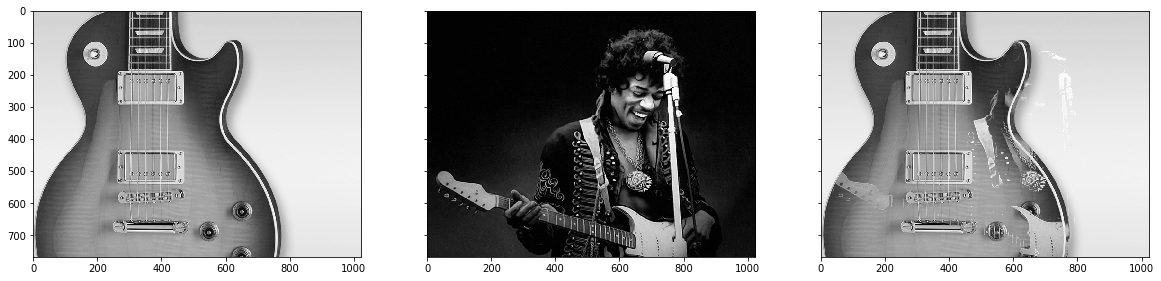

In [7]:
print("\n\nCalculating union...")
%time gunion = union(image1, image2)

f, axarr = plt.subplots(1,3, figsize=(20,20), sharey=True)
axarr[0].imshow(image1, cmap = 'gray')
axarr[1].imshow(image2, cmap = 'gray')
axarr[2].imshow(gunion, cmap = 'gray')
plt.show()

**6. Intersection**



Calculating intersection...
CPU times: user 318 ms, sys: 3.59 ms, total: 321 ms
Wall time: 349 ms


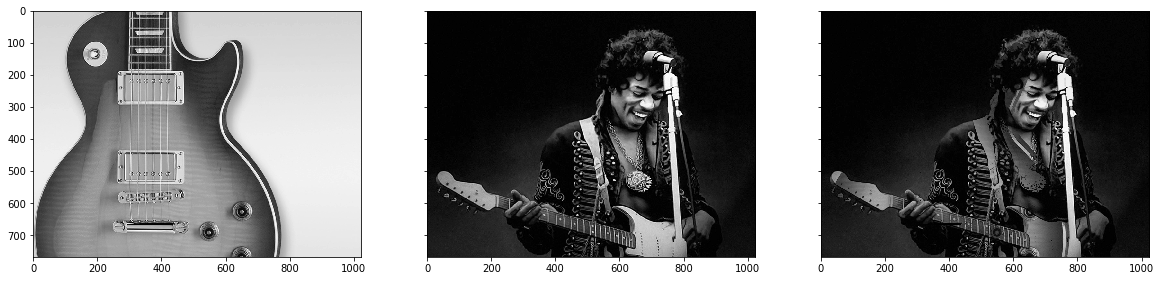

In [9]:
print("\n\nCalculating intersection...")
%time gintersection = intersection(image1, image2)

f, axarr = plt.subplots(1,3, figsize=(20,20), sharey=True)
axarr[0].imshow(image1, cmap = 'gray')
axarr[1].imshow(image2, cmap = 'gray')
axarr[2].imshow(gintersection, cmap = 'gray')
plt.show()

**7. Complement**



Calculating intersection...
CPU times: user 315 ms, sys: 4 µs, total: 315 ms
Wall time: 317 ms


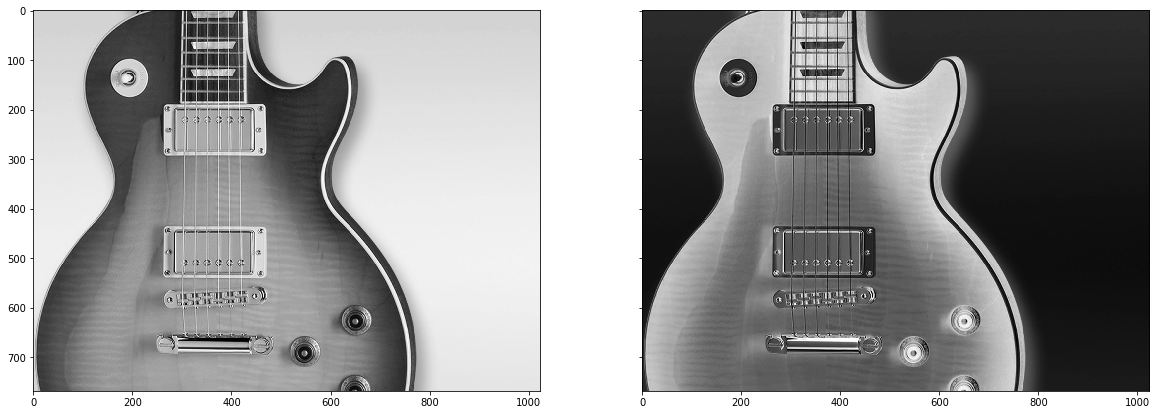

In [13]:
print("\n\nCalculating complement...")
%time gcomplement = complement(image1)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(image1, cmap = 'gray')
axarr[1].imshow(gcomplement, cmap = 'gray')
plt.show()

**8. Definiendo máscara para erode, dilate, opening and closing**

In [15]:
a = np.array([
    [5,5,5]
], dtype=np.uint8)
start = [0,1]
amap_reflected = reflection(a, start)
amap = getmap(a, start)

**9. Erode**



Calculating erode...
CPU times: user 5.69 s, sys: 51.9 ms, total: 5.74 s
Wall time: 5.7 s
CPU times: user 5.84 s, sys: 36.4 ms, total: 5.87 s
Wall time: 5.83 s


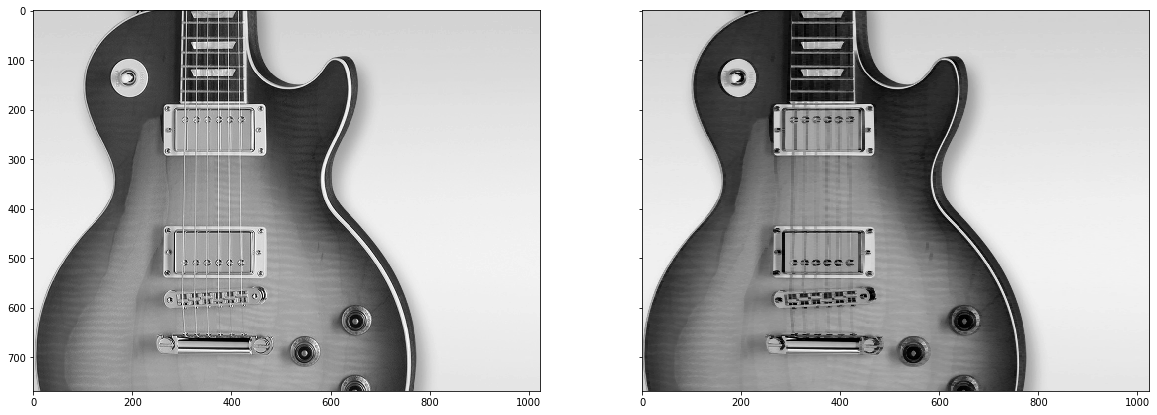

In [17]:
print("\n\nCalculating erode...")
%time gerode = erode(image1, amap)
%time gerode = erode(gerode, amap)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(image1, cmap = 'gray')
axarr[1].imshow(gerode, cmap = 'gray')
plt.show()

**10. Dilate**



Calculating dilate...
CPU times: user 5.57 s, sys: 55.9 ms, total: 5.63 s
Wall time: 5.67 s
CPU times: user 5.67 s, sys: 27.9 ms, total: 5.7 s
Wall time: 5.7 s


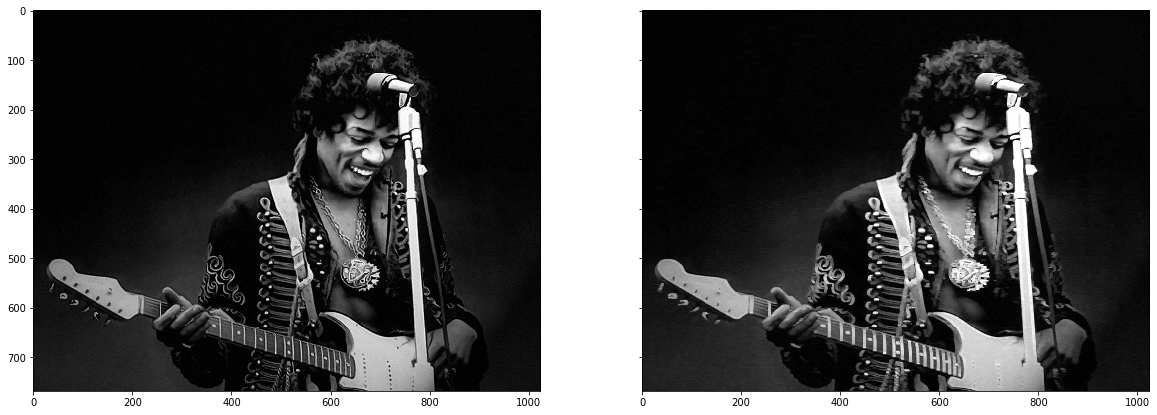

In [19]:
print("\n\nCalculating dilate...")
%time gdilate = dilate(image2, amap_reflected)
%time gdilate = dilate(gdilate, amap)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(image2, cmap = 'gray')
axarr[1].imshow(gdilate, cmap = 'gray')
plt.show()

**11. Opening**



Calculating Opening...
	 Calculating erode
CPU times: user 5.34 s, sys: 48.1 ms, total: 5.38 s
Wall time: 5.35 s
	 Calculating dilate
CPU times: user 5.02 s, sys: 43.7 ms, total: 5.06 s
Wall time: 5.03 s


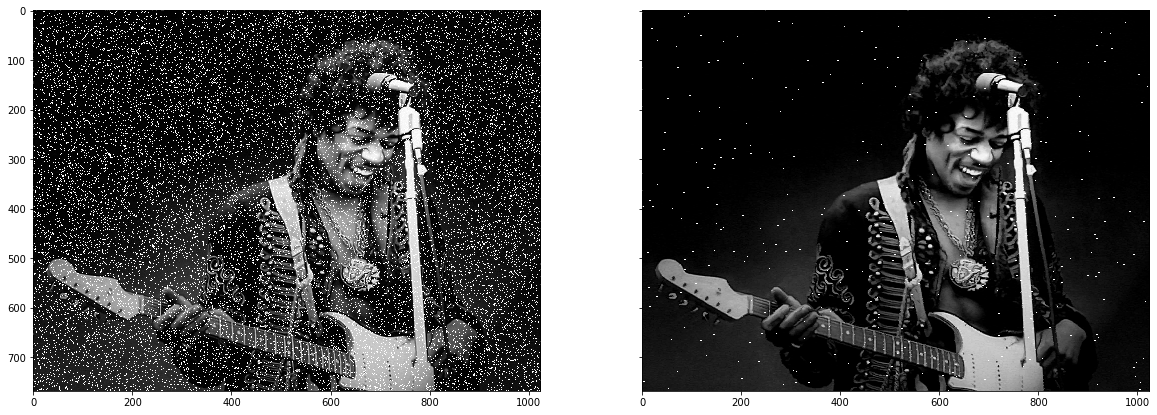

In [21]:
print("\n\nCalculating Opening...")
print("\t Calculating erode")
%time o_erode = erode(image2_noisy, amap)
print("\t Calculating dilate")
%time o = dilate(o_erode, amap_reflected)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(image2_noisy, cmap = 'gray')
axarr[1].imshow(o, cmap = 'gray')
plt.show()

**12. Closing**



Calculating Opening...
	 Calculating dilate
CPU times: user 5.34 s, sys: 20.3 ms, total: 5.36 s
Wall time: 5.31 s
	 Calculating erode
CPU times: user 5.66 s, sys: 40.5 ms, total: 5.7 s
Wall time: 5.67 s


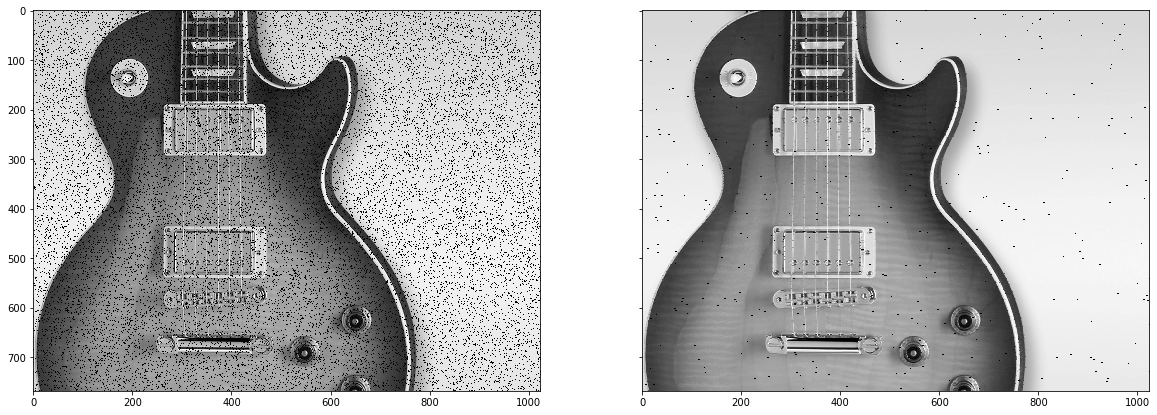

In [22]:
print("\n\nCalculating Opening...")
print("\t Calculating dilate")
%time c_dilate = dilate(image1_noisy, amap_reflected)
print("\t Calculating erode")
%time c = erode(c_dilate, amap)

f, axarr = plt.subplots(1,2, figsize=(20,20), sharey=True)
axarr[0].imshow(image1_noisy, cmap = 'gray')
axarr[1].imshow(c, cmap = 'gray')
plt.show()